# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

## 0. Import Requirements

In [679]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily, Hourly
import datetime
import seaborn as sns
import torch
import torch.nn as nn
from copy import deepcopy as dc
import holidays
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## 1. Data Exploration

In [680]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/new_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [681]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      3782 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [682]:
visitor_data.describe()

,value
count,3782.000000
mean,2.870968
std,3.526116
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,20.000000


<Axes: xlabel='timestemp'>

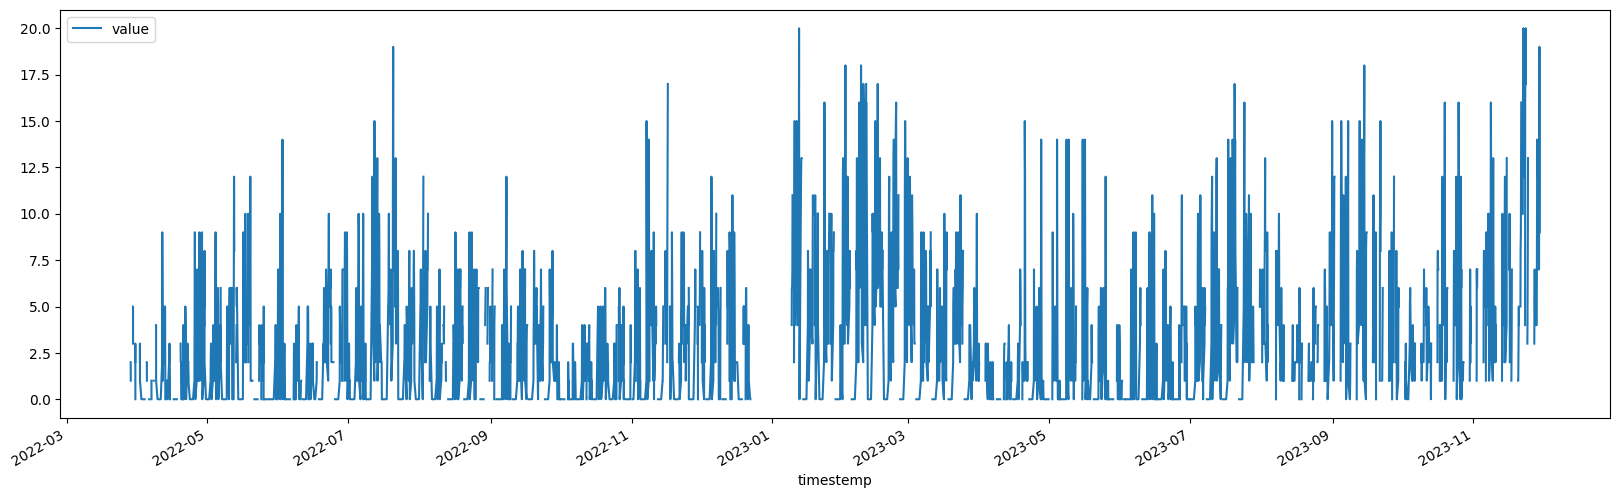

In [683]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 2. Data Preprocessing

- Missing Values
- Sequenz der Vergangenheitswerte
- Datum extrahieren
- Wochentag anhand des Datums herausfinden
- Wochentag oder Wochenende?
    - alle Wocheendtage = 0
- Prüfungsphase hinzufügen
- Holiday/Ferien/Feiertage
- Wetterdaten

In [684]:
# Missing Values Handling
visitor_data['value'] = visitor_data['value'].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)

<Axes: xlabel='timestemp'>

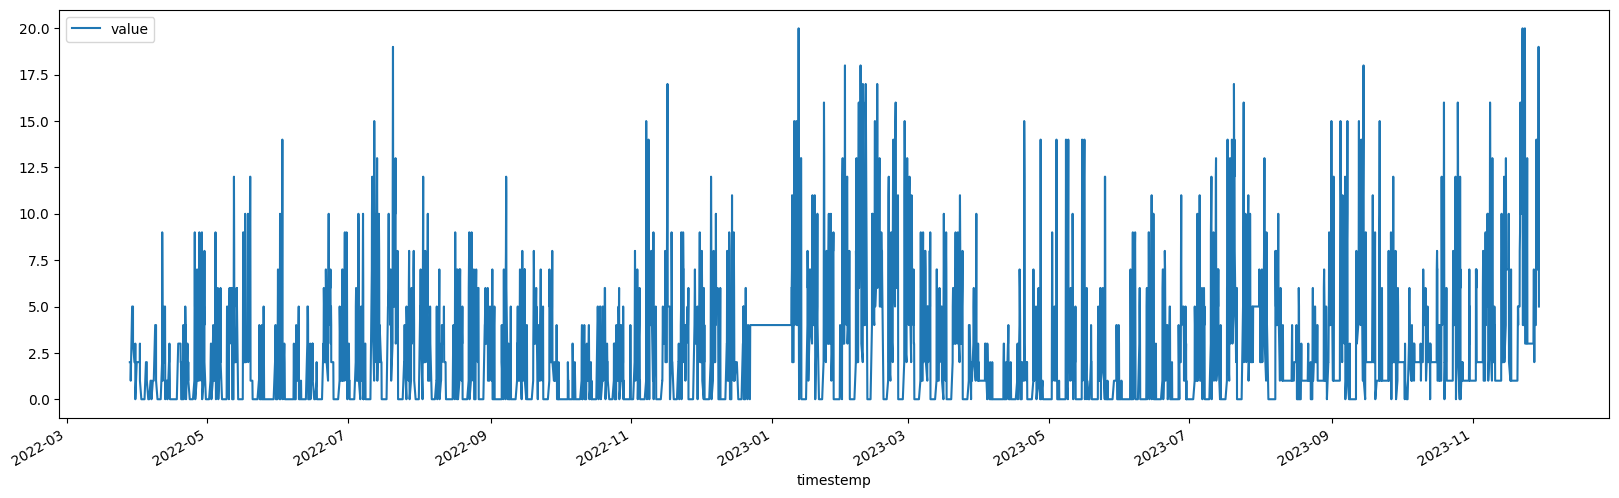

In [685]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

In [686]:
# das Datum extrahieren
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list

#visitor_data

In [687]:
# add column "weekday"
visitor_data["weekday"] = [weekday for weekday in visitor_data["timestemp"].dt.dayofweek]
#visitor_data

In [688]:
# Check if weekday or weekend
weekend_list = []

for timestemp in visitor_data['weekday']:
    if timestemp == 5 or timestemp == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

visitor_data['weekend'] = weekend_list
#visitor_data

In [689]:
# Set all values, where weekend day is 1 to 0
visitor_data.loc[visitor_data['weekend'].eq(1), 'value'] = 0
#visitor_data[["value", "weekend"]]

In [690]:
# Vorlesungspahse = 0, Pfürungsphase = 1
exam_phase_ws_2021_begin = datetime.datetime(2022, 2, 10)
exam_phase_ws_2021_end = datetime.datetime(2022, 3, 31)

exam_phase_ss_2022_begin = datetime.datetime(2022, 7, 20)
exam_phase_ss_2022_end = datetime.datetime(2022, 9, 30)

exam_phase_ws_2022_begin = datetime.datetime(2023, 2, 10)
exam_phase_ws_2022_end = datetime.datetime(2023, 3, 31)

exam_phase_ss_2023_begin = datetime.datetime(2023, 7, 20)
exam_phase_ss_2023_end = datetime.datetime(2023, 9, 30)

exam_phase_ws_2023_begin = datetime.datetime(2024, 2, 10)
exam_phase_ws_2023_end = datetime.datetime(2024, 3, 31)

In [691]:
# Exam Phase
# exam phase == 1, lecture phase == 0

exam_phase_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= exam_phase_ws_2021_begin and timestemp <= exam_phase_ws_2021_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2022_begin and timestemp <= exam_phase_ss_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2022_begin and timestemp <= exam_phase_ws_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2023_begin and timestemp <= exam_phase_ss_2023_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2023_begin and timestemp <= exam_phase_ws_2023_end:
        exam_phase_list.append(1)
    else:
        exam_phase_list.append(0)

exam_phase_list

visitor_data['exam_phase'] = exam_phase_list
# visitor_data

In [692]:
# Check if holiday, or not; holiday = 1, else = 0

de_holidays = holidays.country_holidays('DE', subdiv='BW')

holiday_array = []

for date in visitor_data['date']:
    if date in de_holidays:
        holiday_array.append(1)
    else:
        holiday_array.append(0)

visitor_data['holiday'] = holiday_array

visitor_data.loc[visitor_data['holiday'].eq(1), 'value'] = 0

# visitor_data

In [693]:
# Set the values of the winter vacations to 0, and holiday to 1

# We should do it for other vacations as well

wv_begin_2022 = datetime.datetime(2022, 12, 23)
wv_end_2022 = datetime.datetime(2023, 1, 8)

wv_begin_2023 = datetime.datetime(2023, 12, 23)
wv_end_2023 = datetime.datetime(2024, 1, 7)

wv_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= wv_begin_2022 and timestemp <= wv_end_2022:
        wv_list.append(1)
    elif timestemp >= wv_begin_2023 and timestemp <= wv_end_2023:
        wv_list.append(1)
    else:
        wv_list.append(0)

visitor_data['winter_vacation'] = wv_list

visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'value'] = 0
visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'holiday'] = 1

In [694]:
# Die Vergangeheitswerte t-1 etc. bekommen
def prepare_dateframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps + 1):
        df[f'value (t-{i})'] = df['value'].shift(i)
    
    df.dropna(inplace=True)

    return df

lookback = 114 # Hier rumspielen
visitor_data = prepare_dateframe_for_lstm(visitor_data, lookback)
#visitor_data

# wenn wir zwei Wochen übergeben wollen, müssen wir 8*14=114 Werte zurück gehen...

In [695]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])

# get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-30,9.0,5.6,11.5,0.0,0.0,210.0,11.2,42.8,1017.0,194.0
2023-12-31,6.4,3.5,9.4,0.4,0.0,176.0,15.1,51.1,1008.8,1.0
2024-01-01,6.8,5.1,8.5,0.0,NaN,202.0,16.2,50.0,1012.1,NaN


In [696]:
# weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
# plt.show()

<Axes: xlabel='timestemp'>

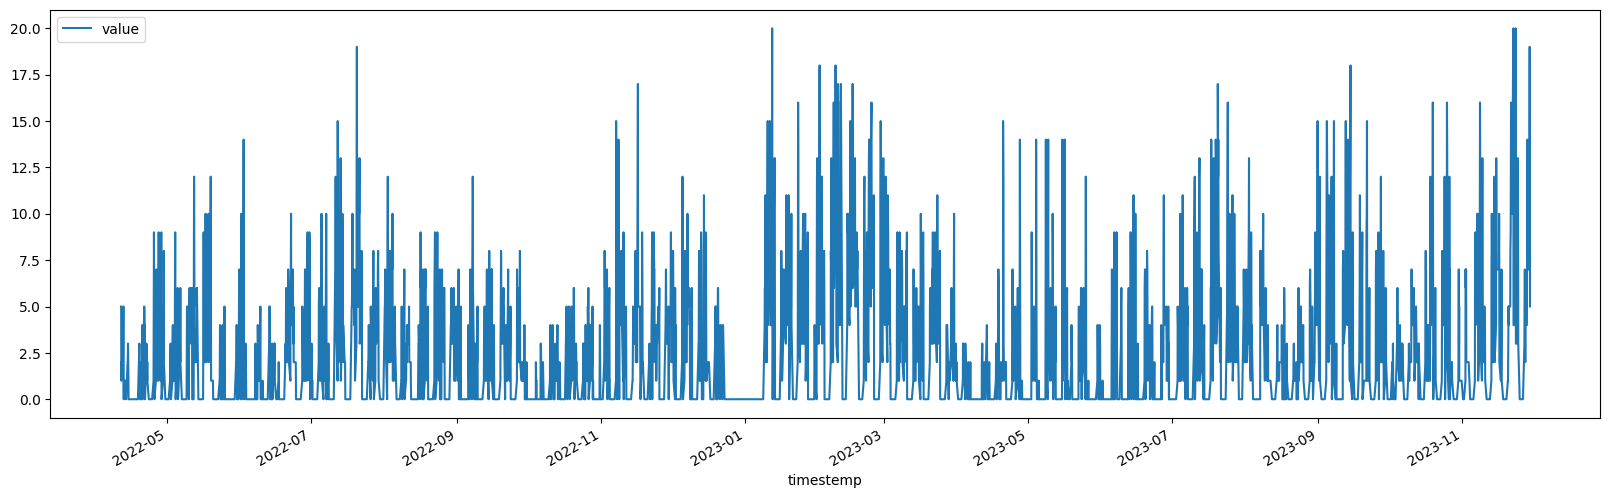

In [697]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

In [698]:
# # merge data frames
# visitor_data = visitor_data.merge(
#     weather_data,
#     left_on="date",
#     right_on="time"
# )

# visitor_data

In [699]:
visitor_data.set_index('timestemp', inplace=True)
visitor_data

,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),value (t-3),...,value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112),value (t-113),value (t-114)
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,2.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,9.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
2022-04-11 18:00:00,3.0,2022-04-11,0,0,0,0,0,1.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
2022-04-11 18:30:00,2.0,2022-04-11,0,0,0,0,0,3.0,1.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 13:45:00,19.0,2023-11-29,2,0,0,0,0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,13.0,4.0
2023-11-29 16:15:00,19.0,2023-11-29,2,0,0,0,0,19.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,13.0
2023-11-29 17:45:00,9.0,2023-11-29,2,0,0,0,0,19.0,19.0,7.0,...,10.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


In [700]:
#calculate correlations between all features of your data frame (see Exploration lab)
data_corr = visitor_data.corr()
print(data_corr)

                  value   weekday   weekend  exam_phase   holiday  \
value          1.000000 -0.413633 -0.457040    0.124245 -0.172414   
weekday       -0.413633  1.000000  0.790664    0.002961 -0.054715   
weekend       -0.457040  0.790664  1.000000   -0.007144 -0.051118   
exam_phase     0.124245  0.002961 -0.007144    1.000000 -0.164272   
holiday       -0.172414 -0.054715 -0.051118   -0.164272  1.000000   
...                 ...       ...       ...         ...       ...   
value (t-110)  0.295075 -0.394066 -0.389317    0.206308 -0.013364   
value (t-111)  0.425502 -0.411166 -0.438813    0.207413 -0.003751   
value (t-112)  0.511490 -0.415487 -0.457314    0.208240 -0.004252   
value (t-113)  0.435031 -0.394493 -0.446820    0.208233 -0.005333   
value (t-114)  0.307802 -0.366002 -0.431270    0.208364 -0.006992   

               winter_vacation  value (t-1)  value (t-2)  value (t-3)  \
value                -0.120226     0.756963     0.540645     0.382854   
weekday               0.0

In [701]:
# # Compute the correlation matrix for all columns
# correlation_matrix = visitor_data.corr()

# # Create a heatmap of the entire correlation matrix
# plt.figure(figsize=(20, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
# plt.title('Correlation Matrix (Training Data)')
# plt.show()

In [702]:
data_corr_label = visitor_data.iloc[:, :].corr()["value"]
data_corr_label[:10]

value              1.000000
weekday           -0.413633
weekend           -0.457040
exam_phase         0.124245
holiday           -0.172414
winter_vacation   -0.120226
value (t-1)        0.756963
value (t-2)        0.540645
value (t-3)        0.382854
value (t-4)        0.309110
Name: value, dtype: float64

## 3. Prepare Data for Model

In [703]:
droplist = ['date', 'winter_vacation', 'weekend', 'holiday', 'exam_phase']

visitor_data = visitor_data.drop(droplist, axis=1)

visitor_data

,value,weekday,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),value (t-7),value (t-8),...,value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112),value (t-113),value (t-114)
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 13:45:00,5.0,0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 16:15:00,5.0,0,5.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 17:45:00,1.0,0,5.0,5.0,9.0,2.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
2022-04-11 18:00:00,3.0,0,1.0,5.0,5.0,9.0,2.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
2022-04-11 18:30:00,2.0,0,3.0,1.0,5.0,5.0,9.0,2.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 13:45:00,19.0,2,7.0,7.0,7.0,11.0,11.0,12.0,14.0,10.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,13.0,4.0
2023-11-29 16:15:00,19.0,2,19.0,7.0,7.0,7.0,11.0,11.0,12.0,14.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,13.0
2023-11-29 17:45:00,9.0,2,19.0,19.0,7.0,7.0,7.0,11.0,11.0,12.0,...,10.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


In [704]:
visitor_data.shape

(4781, 116)

In [705]:
new_visitor_data = visitor_data.to_numpy()
new_visitor_data

array([[ 5.,  0.,  9., ...,  2.,  2.,  2.],
       [ 5.,  0.,  5., ...,  2.,  2.,  2.],
       [ 1.,  0.,  5., ...,  2.,  2.,  2.],
       ...,
       [ 9.,  2., 19., ...,  7.,  7.,  7.],
       [ 5.,  2.,  9., ...,  7.,  7.,  7.],
       [ 5.,  2.,  5., ...,  7.,  7.,  7.]])

In [706]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

new_visitor_data = scaler.fit_transform(new_visitor_data)

new_visitor_data

array([[0.25      , 0.        , 0.45      , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.25      , 0.        , 0.25      , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.05      , 0.        , 0.25      , ..., 0.1       , 0.1       ,
        0.1       ],
       ...,
       [0.45      , 0.33333333, 0.95      , ..., 0.35      , 0.35      ,
        0.35      ],
       [0.25      , 0.33333333, 0.45      , ..., 0.35      , 0.35      ,
        0.35      ],
       [0.25      , 0.33333333, 0.25      , ..., 0.35      , 0.35      ,
        0.35      ]])

In [707]:
# Split into features and labels

data_features = new_visitor_data[:, 1:]
data_labels = new_visitor_data[:, 0]

data_features.shape, data_labels.shape

((4781, 115), (4781,))

In [708]:
data_features = dc(np.flip(data_features, axis=1))
data_features

array([[0.1       , 0.1       , 0.1       , ..., 0.1       , 0.45      ,
        0.        ],
       [0.1       , 0.1       , 0.1       , ..., 0.45      , 0.25      ,
        0.        ],
       [0.1       , 0.1       , 0.1       , ..., 0.25      , 0.25      ,
        0.        ],
       ...,
       [0.35      , 0.35      , 0.35      , ..., 0.95      , 0.95      ,
        0.33333333],
       [0.35      , 0.35      , 0.35      , ..., 0.95      , 0.45      ,
        0.33333333],
       [0.35      , 0.35      , 0.35      , ..., 0.45      , 0.25      ,
        0.33333333]])

In [709]:
split_index = int(len(data_features) * 0.8)
split_index

# Train test Split

train_features = data_features[:split_index]
test_features = data_features[split_index:]

train_labels = data_labels[:split_index]
test_labels = data_labels[split_index:]

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((3824, 115), (957, 115), (3824,), (957,))

In [710]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((3824, 115), (3824,), (957, 115), (957,))

In [711]:
goback = len(visitor_data.columns) -1

train_features = train_features.reshape((-1, goback, 1))
test_features = test_features.reshape((-1, goback, 1))

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((3824, 115, 1), (957, 115, 1), (3824, 1), (957, 1))

In [712]:
# Turn the data into tensors

train_features = torch.tensor(train_features).float()
train_labels = torch.tensor(train_labels).float()

test_features = torch.tensor(test_features).float()
test_labels = torch.tensor(test_labels).float()

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

(torch.Size([3824, 115, 1]),
 torch.Size([957, 115, 1]),
 torch.Size([3824, 1]),
 torch.Size([957, 1]))

### Dataset and DataLoader

In [713]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(train_features, train_labels)
test_dataset = TimeSeriesDataset(test_features, test_labels)

In [714]:
train_dataset, test_dataset

(<__main__.TimeSeriesDataset at 0x13f9eeb9310>,
 <__main__.TimeSeriesDataset at 0x13ffe224210>)

In [715]:
BS = 4

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

for x, y in train_loader:
    print(f"Input Batch Shape: {x.shape} - (batch size, Features, scalar label)")
    print(f"Label Batch Shape: {y.shape} - (batch size, label dimension)")
    break

Input Batch Shape: torch.Size([4, 115, 1]) - (batch size, Features, scalar label)
Label Batch Shape: torch.Size([4, 1]) - (batch size, label dimension)


In [716]:
loss_list = []

## 4. Build Model

In [717]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(LSTMModel, self).__init__()

        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (
            torch.zeros(num_layers, 1, self.hidden_layer_size),
            torch.zeros(num_layers, 1, self.hidden_layer_size),
        )

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            input_seq.view(len(input_seq), 1, -1), self.hidden_cell
        )
        predictions = self.linear(lstm_out.view(len(input_seq), -1))

        return predictions


input_size = goback
hidden_layer_size = 100

# predict a single value
output_size = 1
num_layers = 1

model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 3

for epoch in range(epochs):
    # reset the hidden state at each loop
    model.hidden_cell = (
        torch.zeros(num_layers, 1, model.hidden_layer_size),
        torch.zeros(num_layers, 1, model.hidden_layer_size),
    )

    for i, (X_batch, y_batch) in enumerate(train_loader):
        # reset the gradients
        optimizer.zero_grad()

        # prevent backpropagating of the dataset
        model.hidden_cell = (
            model.hidden_cell[0].detach(),
            model.hidden_cell[1].detach(),
        )

        # forward pass
        y_pred = model(X_batch.float())

        # compute loss
        loss = loss_function(y_pred, y_batch.float())
        loss_list.append(loss.detach().numpy())

        # backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

print("Training complete")

Epoch 1/3 Loss: 0.0027302801609039307
Epoch 2/3 Loss: 0.0004893429577350616
Epoch 3/3 Loss: 0.00032351864501833916
Training complete


### Validation

#### MSE and Root MSE

In [718]:
total_loss = 0
count = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch.float())
        loss = loss_function(y_pred, y_batch.float())
        total_loss += loss.item()
        count += 1

mse = total_loss / count
rmse = mse ** 0.5
print(f"Mean Squared Error on test data: {mse}")
print(f"Root Mean Squared Error on test data: {rmse}")

Mean Squared Error on test data: 0.012785525735300023
Root Mean Squared Error on test data: 0.11307309907887031


### Evaluation

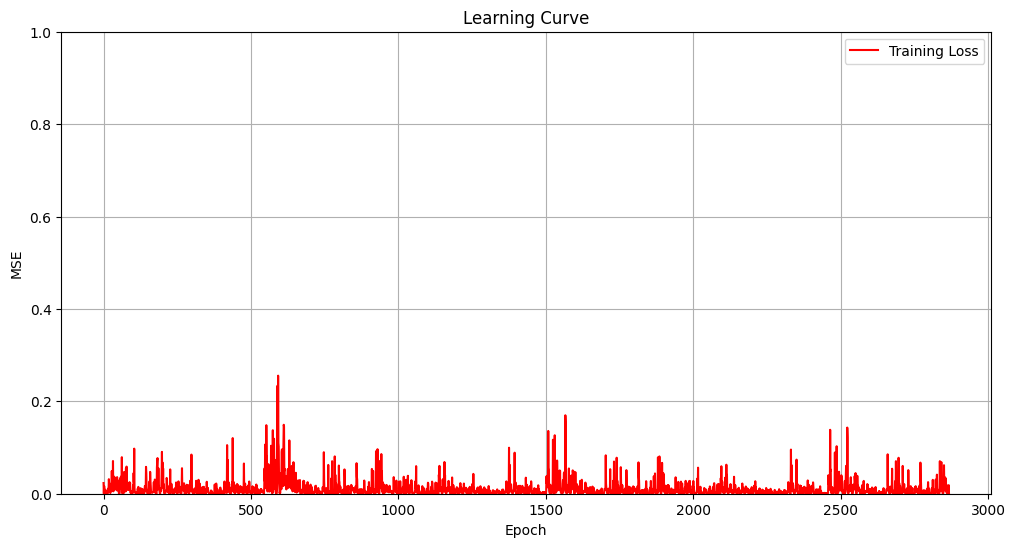

In [719]:
plt.figure(figsize=(12,6))
plt.plot(range(len(loss_list)),loss_list,"r",label="Training Loss")
plt.axis([None, None, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.title("Learning Curve")
plt.show()

In [720]:
test_predictions = model(test_features).detach().numpy().flatten()

dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
# test_predictions

In [721]:
dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_labels.flatten()
dummies = scaler.inverse_transform(dummies)

new_test_labels = dc(dummies[:, 0])
# new_test_labels

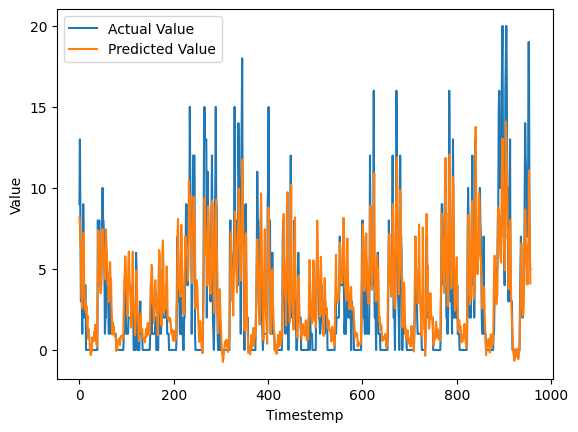

In [722]:
plt.plot(new_test_labels, label='Actual Value')
plt.plot(test_predictions, label='Predicted Value')
plt.xlabel('Timestemp')
plt.ylabel('Value')
plt.legend()
plt.show()